# test code for cancer KZFP figure: figure 4 for KZFP review paper:
- load softwares needed
- download files needed
- plot the location of cancer related KZFPs on chromosomes

KZFP genes loaded (oncogene/TSG): 18
Saved: /Users/qwan/githubRepo/KZFP_review/outputs/cancer_KZFP_loci.pdf
Saved: /Users/qwan/githubRepo/KZFP_review/outputs/cancer_KZFP_loci.svg


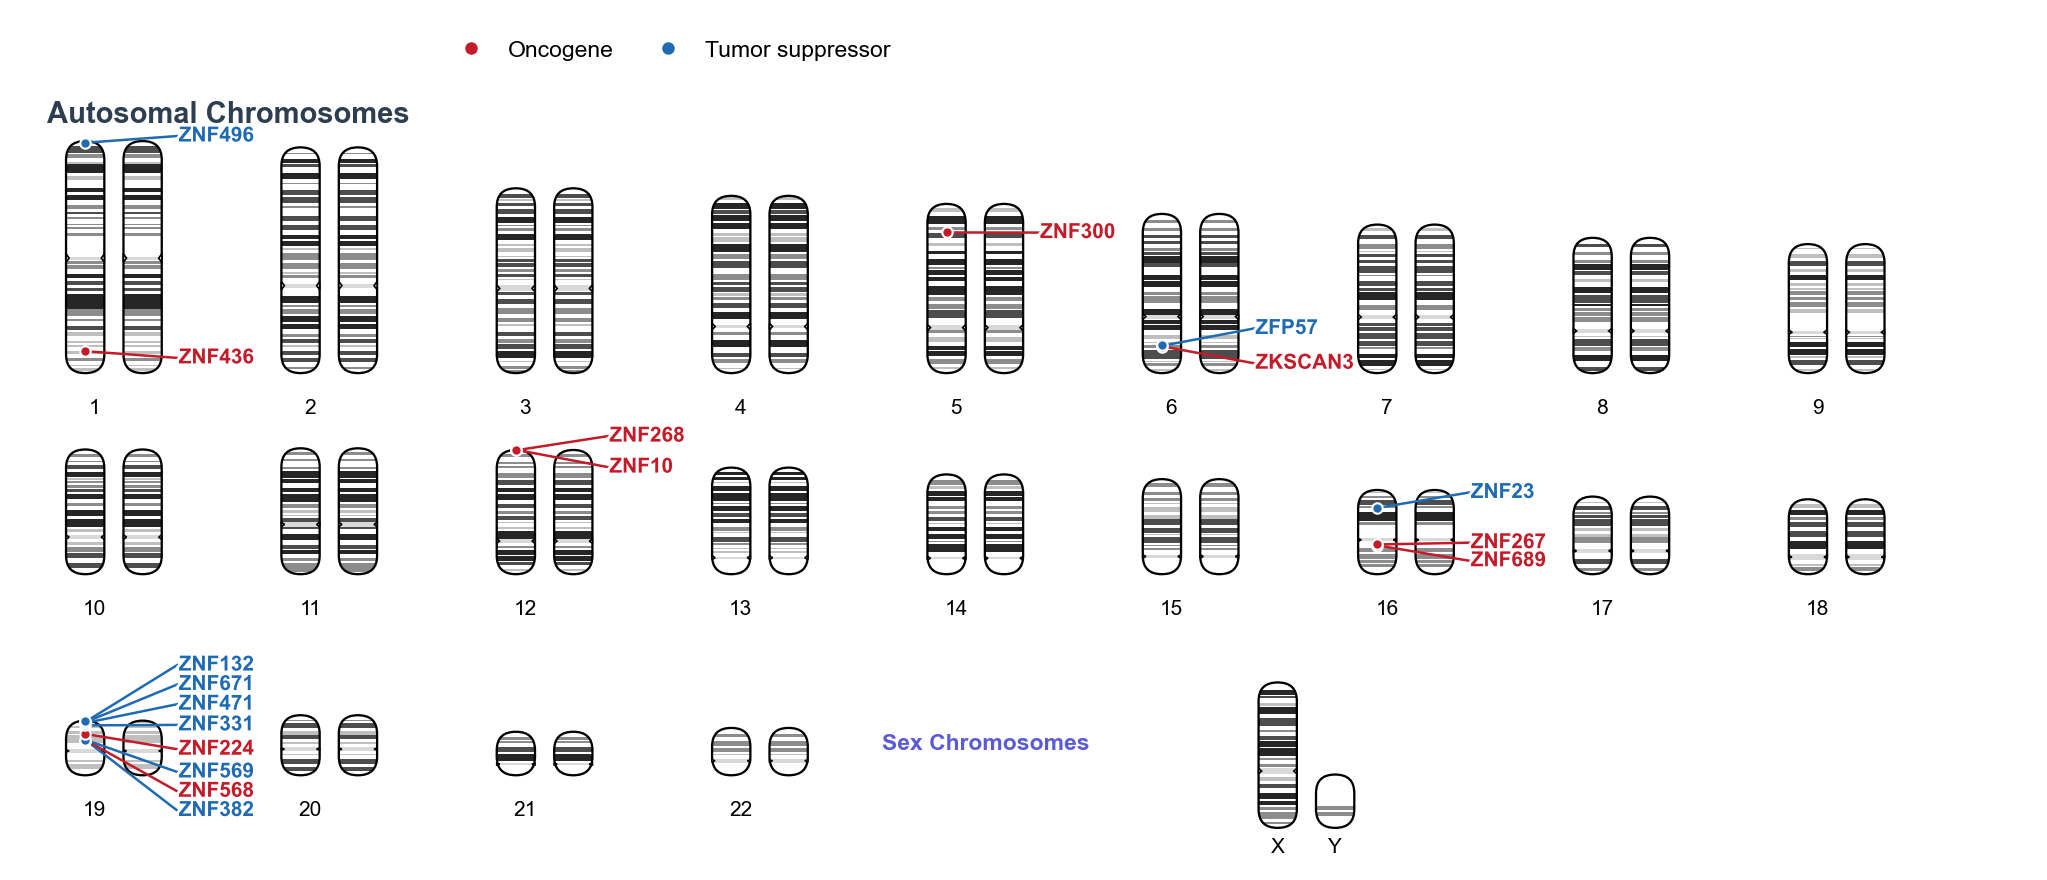

In [32]:
# ============================================
# Nature-style Karyotype with KZFP — v5 (labels in corridor between chromosome pairs)
# ============================================
# %pip install pandas matplotlib

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe

# --------- PATHS ---------
CYTO_PATH = os.path.expanduser("~/githubRepo/KZFP_review/input_data/hg38_cytoBand.txt")
KZFP_BED  = os.path.expanduser("~/githubRepo/KZFP_review/input_data/kzfps_hg38_cancer_geneCoordinates.bed")
BED_IS_ONE_BASED = False

# --------- LOOK & LAYOUT ---------
SEX_TYPE         = "XY"
SCALE_BY_LENGTH  = True
SEX_PANEL_BG     = False
SAVE_DIR         = os.path.expanduser("~/githubRepo/KZFP_review/outputs")
FIG_NAME         = "cancer_KZFP_loci"

# Page/layout
H_MAX  = 1.50
W      = 0.24
GAP    = 0.12
XSTEP  = 1.35
YSTEP  = 1.30
TITLE_FONT = 14

# Label styling
LABEL_FONT   = 10
LABEL_WEIGHT = "bold"
DOT_SIZE     = 5
TEXT_OUTLINE = [pe.Stroke(linewidth=2.8, foreground="white"), pe.Normal()]

# Colors
COLOR_ONCO = "#C51B29"
COLOR_TSG  = "#1F6BB3"

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial","DejaVu Sans","Noto Sans CJK SC","Microsoft YaHei","PingFang SC"],
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
})

# --------- LOADERS ---------
def load_cyto(path):
    return pd.read_csv(path, sep="\t", header=None,
                       names=["chrom","start","end","name","gieStain"])

def load_kzfp_with_group(path, one_based=False):
    df = pd.read_csv(path, sep=r"\s+", header=None)
    if df.shape[1] >= 7:
        df = df.iloc[:, :7]; df.columns = ["chrom","start","end","name","score","strand","group"]
    elif df.shape[1] >= 6:
        df = df.iloc[:, :6]; df.columns = ["chrom","start","end","name","score","strand"]; df["group"]=""
    elif df.shape[1] >= 4:
        df = df.iloc[:, :4]; df.columns = ["chrom","start","end","name"]; df["score"]=0; df["strand"]="."; df["group"]=""
    else:
        df = df.iloc[:, :3]; df.columns = ["chrom","start","end"]; df["name"]=""; df["score"]=0; df["strand"]="."; df["group"]=""

    df = df[df["chrom"].str.startswith("chr")].copy()
    df["start"]=df["start"].astype(int); df["end"]=df["end"].astype(int)
    if one_based: df["start"] = df["start"] - 1
    df["mid"] = ((df["start"]+df["end"])//2).astype(int)

    role_map = {
        "oncogene":"oncogene", "onco":"oncogene", "og":"oncogene",
        "repressor":"tsg", "tsg":"tsg",
        "tumor_suppressor":"tsg", "tumor-suppressor":"tsg", "tumor suppressor":"tsg"
    }
    df["role"] = df["group"].astype(str).str.strip().str.lower().map(role_map)
    df = df[df["role"].isin(["oncogene","tsg"])].copy()
    return df

cyto = load_cyto(CYTO_PATH)
chrom_size = cyto.groupby("chrom")["end"].max().to_dict()
ALL_CHROMS = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY"]
ALL_CHROMS = [c for c in ALL_CHROMS if c in chrom_size]

kzfp = load_kzfp_with_group(KZFP_BED, BED_IS_ONE_BASED)
kzfp = kzfp[kzfp["chrom"].isin(ALL_CHROMS)].copy()
print("KZFP genes loaded (oncogene/TSG):", len(kzfp))

# --------- HELPERS ---------
def subbands(chrom):
    return cyto.loc[cyto["chrom"].eq(chrom)].sort_values("start")

def band_gray(stain: str):
    s = str(stain)
    if s.startswith("gpos100") or s == "gpos": return (0.15,0.15,0.15)
    if s.startswith("gpos75"):  return (0.30,0.30,0.30)
    if s.startswith("gpos50"):  return (0.55,0.55,0.55)
    if s.startswith("gpos25"):  return (0.75,0.75,0.75)
    if s == "acen":             return (0.85,0.85,0.85)
    return (1,1,1)

# --------- DRAW ONE CAPSULE ---------
def draw_chromosome_capsule(ax, x, y, h, w, bands_df, L_bp, show_centromere=True):
    r = w/2.0
    base = patches.FancyBboxPatch(
        (x,y), w,h,
        boxstyle=patches.BoxStyle("Round", pad=0, rounding_size=r),
        facecolor="white", edgecolor="none", zorder=2
    )
    ax.add_patch(base)
    for _, b in bands_df.sort_values("start").iterrows():
        s,e,stain = int(b["start"]), int(b["end"]), b["gieStain"]
        y0 = y + (s/L_bp)*h
        hh = max(1e-6, (e-s)/L_bp*h)
        band = patches.Rectangle((x,y0), w,hh, facecolor=band_gray(stain), edgecolor="none", zorder=3)
        band.set_clip_path(base); ax.add_patch(band)
    ax.add_patch(patches.FancyBboxPatch(
        (x,y), w,h, boxstyle=patches.BoxStyle("Round", pad=0, rounding_size=r),
        facecolor="none", edgecolor="black", linewidth=1.1, zorder=5
    ))
    if show_centromere:
        ac = bands_df[bands_df["gieStain"].eq("acen")]
        if len(ac):
            cy_bp = 0.5*(ac["start"].min() + ac["end"].max())
            cy = y + (cy_bp/L_bp)*h
            notch = w*0.08; span = h*0.018
            ax.add_patch(patches.Polygon([(x,cy-span),(x+notch,cy),(x,cy+span)],
                                         closed=True, facecolor="white", edgecolor="black", linewidth=0.8, zorder=6))
            ax.add_patch(patches.Polygon([(x+w,cy-span),(x+w-notch,cy),(x+w,cy+span)],
                                         closed=True, facecolor="white", edgecolor="black", linewidth=0.8, zorder=6))



# --------- OVERLAY KZFP LABELS (compact small-N version) ---------
def overlay_kzfp_columns(
    ax, kzfp, chrom_info, row1, row2, row3,
    *,
    W, GAP,
    color_onco="#C51B29", color_tsg="#1F6BB3",
    dot_size=5, label_font=10, label_weight="bold",
    text_outline=None,
    # geometry / spacing
    min_dy=0.024,         # minimal vertical spacing within a column (axes coords)
    pad_y=0.03,           # top/bottom padding inside each chromosome
    bias=0.35,            # corridor X position bias toward the current pair (0~0.5)
    col_gap=0.14,         # spacing between multiple text columns in a corridor (axes coords)
    max_cols=3,           # maximum columns per corridor
    # NEW: compact placement for chromosomes with few labels
    small_n=3,            # if n_labels <= small_n, use compact vertical window
    small_pad=0.02,       # extra padding around [min(target_y), max(target_y)] (axes coords)
    small_min_span=0.12   # minimum vertical span for compact window (axes coords)
):
    """
    Place KZFP labels in the 'corridors' between chromosome pairs.
    - Column-aligned labels with short leader lines.
    - Automatic vertical de-overlap packing.
    - For chromosomes with few labels (<= small_n), keep them compact vertically.

    chrom_info: dict like {chrom: (cx, y0, Hc, Lbp, x1[, x2])}
      cx   : x center (not used here)
      y0   : top y of the chromosome in axes coords
      Hc   : height of chromosome capsule (axes coords)
      Lbp  : chromosome length in bp
      x1   : left chromosome's left x
      x2   : (optional) right capsule's left x for this pair. If absent, x2 = x1 + W + GAP
    """
    if kzfp is None or kzfp.empty:
        return

    import numpy as _np
    COLORS = {"oncogene": color_onco, "tsg": color_tsg}

    # ---- helper: 1D packing with min spacing ----
    def pack_1d(y_targets, ymin, ymax, dy):
        y = _np.clip(_np.array(sorted(y_targets), dtype=float), ymin, ymax)
        for i in range(1, len(y)):                 # push up
            y[i] = max(y[i], y[i-1] + dy)
        if len(y):
            overflow = y[-1] - ymax
            if overflow > 0:
                y -= overflow                      # compress down if overflow
        for i in range(len(y)-2, -1, -1):          # relax back down (less drift)
            y[i] = min(y[i], y[i+1] - dy)
        return _np.clip(y, ymin, ymax)

    def _x2_from_x1(x1):
        return x1 + W + GAP

    # ---- compute corridors: for each chromosome, an X pos and side ----
    corridors = {}  # chrom -> (x_corr, side["R"/"L"], y0, Hc)
    for row in (row1, row2, row3):
        seq = [c for c in row if c in chrom_info]
        for i, ch in enumerate(seq):
            cx, y0, Hc, Lbp, x1, *rest = chrom_info[ch]
            x2 = rest[0] if rest else _x2_from_x1(x1)
            if i < len(seq) - 1:
                nx1 = chrom_info[seq[i+1]][4]
                x_corr = x2 + bias * (nx1 - x2)   # corridor to the right of current pair
                corridors[ch] = (x_corr, "R", y0, Hc)
            else:
                if i > 0:
                    prev = chrom_info[seq[i-1]]
                    px2 = prev[5] if len(prev) >= 6 else _x2_from_x1(prev[4])
                    x_corr = x1 + (1.0 - bias) * (px2 - x1)  # corridor to the left of current pair
                    corridors[ch] = (x_corr, "L", y0, Hc)

    # ---- place labels chromosome by chromosome ----
    for ch, (x_corr, side, y0, Hc) in corridors.items():
        sub = kzfp[kzfp["chrom"] == ch].sort_values("mid")
        if sub.empty:
            continue

        cx, y_base, H_here, Lbp, x1, *rest = chrom_info[ch]
        x2  = rest[0] if rest else _x2_from_x1(x1)

        # basic geometry
        dot_x   = x1 + W/2.0                      # dot on the left homolog centerline
        y_min   = y_base + pad_y
        y_max   = y_base + H_here - pad_y
        h_align = "left" if side == "R" else "right"
        elbow_s = +1 if side == "R" else -1

        # collect target y (gene midpoint mapped to chromosome)
        y_targets, names, roles = [], [], []
        for _, r in sub.iterrows():
            y_tgt = y0 + (int(r["mid"]) / float(Lbp)) * Hc
            y_targets.append(max(min(y_tgt, y_max), y_min))
            names.append(str(r["name"]))
            roles.append(str(r["role"]).lower())
        n = len(y_targets)
        if n == 0:
            continue

        # --- compact window for small-n chromosomes ---
        work_ymin, work_ymax = y_min, y_max
        if n <= small_n:
            tmin, tmax = min(y_targets), max(y_targets)
            span = max(small_min_span, (tmax - tmin) + 2 * small_pad)
            ctr  = 0.5 * (tmin + tmax)
            work_ymin = max(y_min, ctr - 0.5 * span)
            work_ymax = min(y_max, ctr + 0.5 * span)
            # nudge targets into the compact window
            y_targets = [min(max(y, work_ymin), work_ymax) for y in y_targets]

        # number of columns based on capacity within WORKING span
        capacity = max(1, int(_np.floor((work_ymax - work_ymin) / min_dy)))
        ncols    = int(_np.ceil(n / capacity))
        ncols    = max(1, min(max_cols, ncols))

        # column x centers
        if ncols == 1:
            col_xs = [x_corr]
        else:
            half = (ncols - 1) / 2.0
            col_xs = [x_corr + (i - half) * col_gap for i in range(ncols)]

        # distribute into columns (round-robin), then pack within each column
        buckets = [[] for _ in range(ncols)]
        for i_idx, y_t in enumerate(y_targets):
            buckets[i_idx % ncols].append((y_t, i_idx))

        for cidx, bucket in enumerate(buckets):
            if not bucket:
                continue
            tgt_sorted, idx_sorted = zip(*sorted(bucket, key=lambda t: t[0]))
            tgt_sorted = _np.array(tgt_sorted, dtype=float)
            m = len(tgt_sorted)

            # local spacing for this column in the WORKING span
            if m >= 2:
                dy_fill = 0.92 * (work_ymax - work_ymin) / (m - 1)
                dy_loc  = max(min_dy, min(0.05, dy_fill))
            else:
                dy_loc  = min_dy

            # seed positions: bias more toward targets when small-n
            y_even = (_np.linspace(work_ymin, work_ymax, m)
                      if m > 1 else _np.array([(work_ymin + work_ymax) / 2.0]))
            alpha = 0.9 if n <= small_n else 0.6
            y_seed = alpha * tgt_sorted + (1 - alpha) * y_even

            y_pack = pack_1d(y_seed, work_ymin, work_ymax, dy_loc)
            x_txt  = col_xs[cidx]

            # draw dots, short leaders, and labels
            for y_lab, i_idx in zip(y_pack, idx_sorted):
                role  = roles[i_idx]
                color = COLORS.get(role, color_onco)
                y_dot = y_targets[i_idx]  # keep dot on true target; set to y_lab to align if desired

                # dot
                ax.plot(dot_x, y_dot, marker="o", markersize=dot_size,
                        markerfacecolor=color, markeredgecolor="white",
                        linewidth=0, zorder=7)

                # short leader: tiny horizontal + diagonal into column
                elbow1_x = dot_x + elbow_s * 0.012
                elbow2_x = x_txt - elbow_s * 0.010
                ax.plot([dot_x, elbow1_x], [y_dot, y_dot], color=color, linewidth=1.2, zorder=6)
                ax.plot([elbow1_x, elbow2_x], [y_dot, y_lab], color=color, linewidth=1.2, zorder=6)

                txt = ax.text(x_txt, y_lab, names[i_idx],
                              fontsize=label_font, fontweight=label_weight,
                              va="center", ha=h_align, color=color, zorder=7)
                if text_outline:
                    txt.set_path_effects(text_outline)


                        
# --------- MAIN PLOT ---------
def plot_karyotype(cyto, chrom_size, kzfp,
                   sex_type="XY",
                   scale_by_length=SCALE_BY_LENGTH,
                   sex_panel_bg=SEX_PANEL_BG):
    L_MAX = max(chrom_size.values())
    LABEL_DY = -0.16

    row1=[f"chr{i}" for i in range(1,10)]
    row2=[f"chr{i}" for i in range(10,19)]
    row3=[f"chr{i}" for i in range(19,23)]
    for row in (row1,row2,row3):
        for c in list(row):
            if c not in chrom_size: row.remove(c)
    nmax = max(len(row1),len(row2),len(row3))

    fig,ax=plt.subplots(figsize=((1+nmax*XSTEP)*1.32, (0.9+3*YSTEP+1.55)*1.16))
    ax.axis("off")

    # 画自体并收集几何信息：中心x、底y、总高Hc、长度、左同源体x1、右同源体x2
    chrom_info={}
    def draw_row(chrs,y0):
        for i,ch in enumerate(chrs):
            Lbp=float(chrom_size[ch])
            Hc=H_MAX if not scale_by_length else H_MAX*(Lbp/L_MAX)
            cx=0.5+i*XSTEP; x1=cx-(W+GAP)/2; x2=cx+(W+GAP)/2
            draw_chromosome_capsule(ax,x1,y0,Hc,W,subbands(ch),Lbp,show_centromere=True)
            draw_chromosome_capsule(ax,x2,y0,Hc,W,subbands(ch),Lbp,show_centromere=True)
            ax.text(cx,y0+LABEL_DY,ch.replace("chr",""),ha="center",va="top",fontsize=10)
            chrom_info[ch]=(cx,y0,Hc,Lbp,x1,x2)

    draw_row(row1,0.58+2*YSTEP)
    draw_row(row2,0.58+1*YSTEP)
    draw_row(row3,0.58+0*YSTEP)

    # Sex panel（略，保持不变）
    pair=("chrX","chrY") if sex_type.upper()=="XY" else ("chrX","chrX")
    sx=0.5+(nmax*XSTEP-0.4)*0.42; sy=0.17
    box_w=(nmax*XSTEP-0.6)*0.44; box_h=0.56
    ax.text(sx,sy+box_h+0.02,"Sex Chromosomes",fontsize=11,color="#5b5bd6",weight="bold")
    if all(c in chrom_size for c in pair):
        Lx,Ly=float(chrom_size[pair[0]]),float(chrom_size[pair[1]])
        Hx=Hy=min(box_h-0.20,H_MAX) if not scale_by_length else (H_MAX*(Lx/L_MAX), H_MAX*(Ly/L_MAX))
        if isinstance(Hx, tuple): Hx,Hy = Hx
        cx0=sx+box_w/2; by=sy+0.07
        draw_chromosome_capsule(ax,cx0-(W+GAP)/2,by,Hx,W,subbands(pair[0]),Lx,show_centromere=True)
        draw_chromosome_capsule(ax,cx0+(W+GAP)/2,by,Hy,W,subbands(pair[1]),Ly,show_centromere=False)
        ax.text(cx0-(W+GAP)/2+W/2,by-0.06,"X",ha="center",va="top",fontsize=10)
        ax.text(cx0+(W+GAP)/2+W/2,by-0.06,"Y" if sex_type.upper()=="XY" else "X",
                ha="center",va="top",fontsize=10)
        chrom_info[pair[0]]=(cx0,by,Hx,Lx,cx0-(W+GAP)/2,cx0+(W+GAP)/2)
        chrom_info[pair[1]]=(cx0,by,Hy,Ly,cx0-(W+GAP)/2,cx0+(W+GAP)/2)

    ax.text(0.2,0.58+2*YSTEP+H_MAX+0.12,"Autosomal Chromosomes",
            fontsize=TITLE_FONT, weight="bold", color="#2c3e50")

    # ====== 计算“走廊”位置：每个染色体优先用其右侧走廊；行末用左侧走廊 ======
    corridors = {}   # ch -> (x_center, side) side in {"R","L"}
    for row in (row1,row2,row3):
        seq = [ch for ch in row if ch in chrom_info]
        for i,ch in enumerate(seq):
            if i < len(seq)-1:
                # corridor between this chromosome and the next (to the right)
                _,_,_,_,x1_this,x2_this = chrom_info[ch]
                _,_,_,_,x1_next,_        = chrom_info[seq[i+1]]
                corridors[ch] = (0.5*(x2_this + x1_next), "R")
            else:
                # last in row: use corridor to the left (between prev and this)
                if i>0:
                    prev = seq[i-1]
                    _,_,_,_,_,x2_prev = chrom_info[prev]
                    _,_,_,_,x1_curr,_ = chrom_info[ch]
                    corridors[ch] = (0.5*(x2_prev + x1_curr), "L")

    
    overlay_kzfp_columns(
        ax, kzfp, chrom_info, row1, row2, row3,
        W=W, GAP=GAP,
        color_onco=COLOR_ONCO, color_tsg=COLOR_TSG,
        dot_size=DOT_SIZE, label_font=10, label_weight=LABEL_WEIGHT,
        text_outline=TEXT_OUTLINE,
        min_dy=0.036,          # more vertical clearance
        pad_y=-0.9,            
        bias=0.35,
        col_gap=0.18,
        max_cols=1,            # still one column per corridor
        small_n=3,
        small_pad=0.00,
        small_min_span=2.2    # wider compact band so 2–3 labels don't stack
    )


    # Legend inside figure
    handles = [
        Line2D([0],[0], marker='o', color='none', markerfacecolor=COLOR_ONCO,
               markeredgecolor="white", markersize=7, label='Oncogene'),
        Line2D([0],[0], marker='o', color='none', markerfacecolor=COLOR_TSG,
               markeredgecolor="white", markersize=7, label='Tumor suppressor'),
    ]
    ax.legend(handles=handles,
              loc="upper left",
              bbox_to_anchor=(0.21, 0.98),
              borderaxespad=0.0,
              frameon=False,
              fontsize=11,
              ncol=2,
              handletextpad=0.6,
              columnspacing=1.4)

    ax.set_xlim(0, 0.5 + nmax*XSTEP)
    ax.set_ylim(0, 0.60 + 3*YSTEP + 1.00)
    return fig, ax

# --------- RUN & SAVE ---------
fig, ax = plot_karyotype(cyto, chrom_size, kzfp,
                         sex_type=SEX_TYPE,
                         scale_by_length=SCALE_BY_LENGTH,
                         sex_panel_bg=SEX_PANEL_BG)

os.makedirs(SAVE_DIR, exist_ok=True)
for ext in ("pdf","svg"):
    out = os.path.join(SAVE_DIR, f"{FIG_NAME}.{ext}")
    fig.savefig(out, format=ext, bbox_inches="tight")
    print("Saved:", out)

plt.show()


- aspect to imporve:
    - location of label that can be horizontal like ZNF300
    